Generating distorted characters in a variety of fonts and teaching a network to recognize them.
This application will take background patches or noise and generate random text on top of them with tuples of three letters.  The three letters let us predict 'first', 'middle', and 'last' letters so that we can chain together full words.  Transforms include affine and perspective distortions.

In [107]:
%matplotlib inline

import os, shutil
import sys
import math
import json
import random
import pickle
import string
from glob import glob

import numpy
from PIL import Image, ImageDraw, ImageFont, ImageTransform
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape, Activation, LeakyReLU, Add, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard
import matplotlib
import matplotlib.pyplot as plt

print(K.image_data_format()) # Should be channels_last

## Data Generation

In [33]:
# Constants
STRING_LENGTH = 1
TEXT_SIZE = (32, 32)
IMAGE_SIZE = TEXT_SIZE # For now.  We'll want to crop out a section of an image.
FONTS_DIR = "/usr/share/fonts/truetype/"
FONT_CHOICES = glob(os.path.join(FONTS_DIR, "*", "*.ttf"))
FONT_CHOICES = ['/usr/share/fonts/truetype/freefont/FreeSans.ttf', '/usr/share/fonts/truetype/freefont/FreeSerif.ttf', '/usr/share/fonts/truetype/freefont/FreeMono.ttf']
print(FONT_CHOICES)

['/usr/share/fonts/truetype/freefont/FreeSans.ttf', '/usr/share/fonts/truetype/freefont/FreeSerif.ttf', '/usr/share/fonts/truetype/freefont/FreeMono.ttf']


In [3]:
# Crop from an image.
#base = Image.open('Pillow/Tests/images/hopper.png').convert('RGBA')
base = Image.new('RGBA', IMAGE_SIZE,(0, 0, 0, 255))

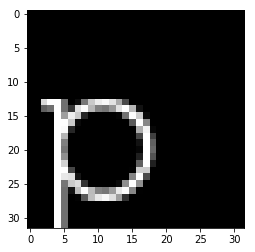

p


In [110]:
# Make a blank image for the text, initialized to transparent text color
printable_chars = [c for c in string.printable if c.isalnum()]
#printable_chars = ['a', 'b'] # DEBUG
def new_text_image(opacity=255, color=(255, 255, 255)):
    txt_image = Image.new('RGBA', TEXT_SIZE, (255,255,255,0))

    # Randomly select a font and a size.
    font_size = random.randint(12, 36)
    fnt = ImageFont.truetype(random.choice(FONT_CHOICES), font_size)

    # Get a drawing context.
    d = ImageDraw.Draw(txt_image)

    # Generate three random characters.
    target_string = "".join([random.choice(printable_chars) for _ in range(STRING_LENGTH)])

    # Full opacity, 1/nth of the way down the image, making it roughly centered.
    x_start = 0 #random.randint(0, TEXT_SIZE[0]//2)
    y_start = 0 #random.randint(0, TEXT_SIZE[1]//3)
    d.text((x_start, y_start), target_string, font=fnt, fill=(color[0], color[1], color[2], opacity)) # 255 = full opacity.
    
    return txt_image, target_string

# DEBUG SAMPLE COMPOSITE:
txt_image, target_str = new_text_image()
out_undistorted = Image.alpha_composite(base, txt_image)
#out.show()
plt.imshow(out_undistorted)
plt.show()
print(target_str)

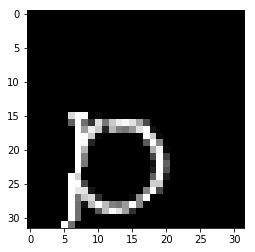

In [111]:
# Make a random transform and distort the text.
def distort_text_image(txt):
    # Upper left, lower left, lower right, upper_right.
    left_min = -10
    left_max = 0
    right_min = TEXT_SIZE[0]-2
    right_max = TEXT_SIZE[0]
    top_min = -10
    top_max = 0
    bottom_min = TEXT_SIZE[1]-2
    bottom_max = TEXT_SIZE[1]
    # Upper left
    x0 = random.randint(left_min, left_max)
    y0 = random.randint(top_min, top_max)
    # Lower left
    x1 = random.randint(left_min, left_max)
    y1 = random.randint(bottom_min, bottom_max)
    # Lower right
    x2 = random.randint(right_min, right_max)
    y2 = random.randint(bottom_min, bottom_max)
    # Upper right
    x3 = random.randint(right_min, right_max)
    y3 = random.randint(top_min, top_max)
    transform = ImageTransform.QuadTransform((x0, y0, x1, y1, x2, y2, x3, y3))
    txt_distorted = transform.transform(TEXT_SIZE, txt)
    return txt_distorted

# DEBUG: Composite
txt_distorted = distort_text_image(txt_image)
out_distorted = Image.alpha_composite(base, txt_distorted)
plt.imshow(out_distorted)
plt.show()

In [ ]:
# This is stolen from here: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# Maybe we want to replace our data augmentation with this method?
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

###

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

## Model Creation

In [91]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        tf.summary.scalar('mean', tf.reduce_mean(var))
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

#def summary(y_true, y_pred):
#    return tf.summary.merge_all()
#model.compile(optimizer=Adagrad(), loss=loss_dict, metrics=[summary])

#summary_writer = tf.summary.FileWriter("logs/" + args.name)

#l = value_policy_model.train_on_batch(x_batch, y_batch)
#l_dict = dict(zip(value_policy_model.metrics_names, l))
#summary_writer.add_summary(l_dict['value_summary'], global_step=iter_idx)
#summary_writer.flush()

In [156]:
K.clear_session()

old_model_err_4 = """
model = Sequential()
# Standard fare convs.
model.add(Conv2D(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), filters=64, kernel_size=(3, 3), strides=(1,1)))
model.add(LeakyReLU())

# Using 2,2 stride on Conv2D instead of max pool seems to perform better.
model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1)))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1,1)))
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

# Begin the flat portion.
model.add(Flatten())

model.add(Dense(512))
model.add(LeakyReLU())
model.add(Dropout(rate=0.5))

model.add(Dense(8))
model.add(LeakyReLU())
model.add(Dropout(rate=0.5))

# Final layer.
model.add(Dense(STRING_LENGTH*(ord('~')+1))) # 3 rows, 128 columns.  Maybe use output_shape?
model.add(LeakyReLU())
model.add(Reshape((STRING_LENGTH, 1+ord('~'))))
model.add(Activation('softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) # NOT binary_xent
#model.compile(optimizer='rmsprop', loss='kullback_leibler_divergence', metrics=['accuracy'])
"""

inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

with tf.name_scope("convolution_layers"):
    x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same')(inputs)
    x = LeakyReLU()(x)
    x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x) #GoogLeNet128_BN_lim0606 does this before ReLU
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)

    x = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x) # 3x3 so we collapse to a single value.
    
    x = Conv2D(filters=512, kernel_size=(1,1), strides=(1,1), padding='same')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

x_flat = Flatten()(x)
x = x_flat

with tf.name_scope("dense_layers"):
    x = Dense(1024)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x) #GoogLeNet128_BN_lim0606 does this before ReLU
    x = Dense(1024)(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dense(1024)(x)
    x = LeakyReLU()(x)

with tf.name_scope("output_layers"):
    x = Dense(STRING_LENGTH*(ord('~')+1))(x)
    x = Reshape((STRING_LENGTH, 1+ord('~')))(x)
    predictions = Activation('softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adadelta(lr=0.1, rho=0.95, decay=0.0)
model.compile(optimizer=opt, loss='categorical_crossentropy')#, metrics=[summary])

not_vgg = """
inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

def model_nodule(x_in, scope_name, filter_count=16):
    with tf.name_scope(scope_name): # Name scope instead of variable_scope because we don't want reuse here.
        x_tiny = Conv2D(filters=filter_count, kernel_size=(1,1), strides=(1,1), padding='same')(x_in)
        x_tiny = LeakyReLU()(x_tiny)
        x_tiny = Flatten()(x_tiny)

        x_small = Conv2D(filters=filter_count, kernel_size=(3,3), strides=(2,2), padding='same')(x_in)
        x_small = LeakyReLU()(x_small)
        x_small = Flatten()(x_small)

        x_big = Conv2D(filters=filter_count, kernel_size=(5,5), strides=(3,3), padding='same')(x_in)
        x_big = LeakyReLU()(x_big)
        x_big = Flatten()(x_big)

        x_huge = Conv2D(filters=filter_count, kernel_size=(7,7), strides=(3,3), padding='same')(x_in)
        x_huge = LeakyReLU()(x_huge)
        x_huge = Flatten()(x_huge)

        #x_max = MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='same')(x_in)
        #x_max = Flatten()(x_max)

        joint = Concatenate()([x_tiny, x_small, x_big, x_huge])
        block = Reshape((int(math.sqrt(filter_count)), int(math.sqrt(filter_count)), -1))(joint)
    
    return block

x = inputs

x = model_nodule(x, "nodule0")
variable_summaries(x)

x_flat = Flatten()(x)
x = x_flat

# Dense tunnel.
with tf.name_scope("dense_pipe"):
    x = Dense(512)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    variable_summaries(x)

    x = Dense(512)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    variable_summaries(x)
    
    x = Dense(512)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.5)(x)
    variable_summaries(x)


x = Dense(STRING_LENGTH*(ord('~')+1))(x)
x = Reshape((STRING_LENGTH, 1+ord('~')))(x)
predictions = Activation('softmax')(x)
variable_summaries(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
"""

print(model.count_params())
print(model.summary())

11130783
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_

## Train

In [126]:
def generator(base_image_selector, batch_size, enable_distortion):
    image_files = glob(base_image_selector)
    batch = numpy.zeros((batch_size, IMAGE_SIZE[0], IMAGE_SIZE[1], 3), dtype=numpy.uint8)
    labels = numpy.zeros((batch_size, STRING_LENGTH, ord('~')+1), dtype=numpy.uint8)
    while True:
        # Load an image.
        base_filename = random.choice(image_files)
        img = Image.open(base_filename).convert('RGBA')
        #img = Image.new('RGBA', IMAGE_SIZE) # DEBUG
        for i in range(batch_size):
            # Cut out a section of it.
            x = random.randint(0, img.size[0]-IMAGE_SIZE[0])
            y = random.randint(0, img.size[1]-IMAGE_SIZE[1])
            right = x+IMAGE_SIZE[0]
            bottom = y+IMAGE_SIZE[1]
            region = img.crop((x, y, right, bottom))
            # Select the average color of this region so we can pick a random color that avoids it.
            average_color = [0, 0, 0]
            num_pixels = IMAGE_SIZE[0]*IMAGE_SIZE[1]
            for y in range(0, IMAGE_SIZE[1]):
                for x in range(0, IMAGE_SIZE[0]):
                    pix = region.getpixel((x, y))
                    average_color[0] += pix[0]
                    average_color[1] += pix[1]
                    average_color[2] += pix[2]
            average_color[0] = int(average_color[0]/num_pixels)
            average_color[1] = int(average_color[1]/num_pixels)
            average_color[2] = int(average_color[2]/num_pixels)
            # Select a color that is very high contrast.
            r = random.randint(average_color[0] + 50, average_color[0] + 150)%255 # Wrap around.
            g = random.randint(average_color[1] + 50, average_color[1] + 150)%255 # Wrap around.
            b = random.randint(average_color[2] + 50, average_color[2] + 150)%255 # Wrap around.
            # Produce a random text image and the matching characters.
            text_image, text_string = new_text_image(opacity=random.randint(230, 255), color=(r, g, b))
            # Distort the text image, maybe.
            if enable_distortion and random.choice((True, False)):
                text_image = distort_text_image(text_image)
            # Superimpose the text on the image.
            out = Image.alpha_composite(region, text_image)
            example = numpy.asarray(out.convert('RGB'))
            # Convert our text into an array of size 3x128
            label = numpy.zeros(shape=(STRING_LENGTH, ord('~')+1), dtype=numpy.uint8)
            for j in range(STRING_LENGTH):
                label[j][ord(text_string[j])] = 1
            # Return our training + label pair
            batch[i,:,:,:] = example[:,:,:]
            labels[i,:,:] = label[:,:]
        yield batch/255.0, labels

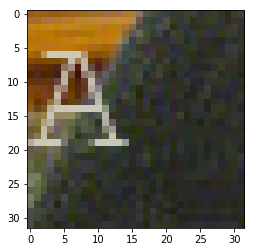

A
(100, 1, 127)
[[ 0.60784314  0.61568627  0.60392157  0.58431373  0.58823529]
 [ 0.65098039  0.64705882  0.68235294  0.69411765  0.69019608]
 [ 0.74117647  0.73333333  0.75294118  0.75686275  0.74117647]
 [ 0.72941176  0.71372549  0.71764706  0.71764706  0.69803922]
 [ 0.72941176  0.71372549  0.72941176  0.7372549   0.73333333]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


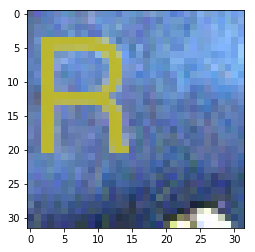

R
(100, 1, 127)
[[ 0.36078431  0.38039216  0.33333333  0.35686275  0.43137255]
 [ 0.33333333  0.36862745  0.34117647  0.38431373  0.40784314]
 [ 0.35686275  0.40784314  0.36078431  0.38039216  0.35686275]
 [ 0.36470588  0.39215686  0.37254902  0.3254902   0.38431373]
 [ 0.38431373  0.43529412  0.73333333  0.73333333  0.7372549 ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


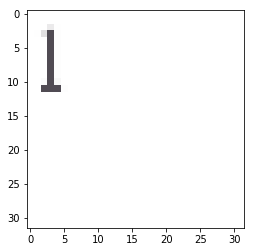

1
(100, 1, 127)
[[ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          1.          0.92156863  0.99607843]
 [ 1.          0.99607843  0.88235294  0.31372549  0.99215686]
 [ 1.          1.          1.          0.31372549  0.99215686]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


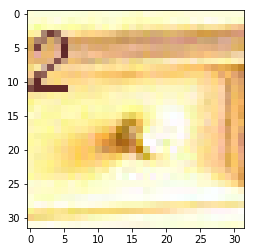

2
(100, 1, 127)
[[ 0.99607843  0.98039216  0.98039216  0.98039216  0.98039216]
 [ 0.98823529  1.          0.99607843  1.          1.        ]
 [ 0.98823529  0.95686275  0.99215686  1.          0.98823529]
 [ 1.          0.99215686  0.6627451   0.43921569  0.57647059]
 [ 0.85882353  0.6745098   0.63921569  0.84705882  0.74117647]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


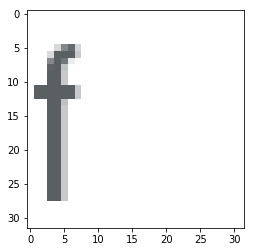

f
(100, 1, 127)
[[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


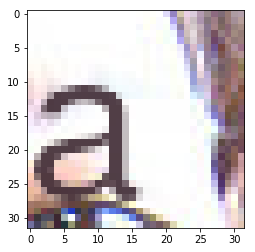

a
(100, 1, 127)
[[ 1.          1.          1.          1.          1.        ]
 [ 0.99607843  0.99607843  0.99607843  1.          1.        ]
 [ 0.99607843  0.99607843  0.99607843  0.99607843  1.        ]
 [ 0.99607843  0.99607843  0.99607843  0.99607843  1.        ]
 [ 0.99607843  0.99607843  0.99607843  0.99607843  1.        ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


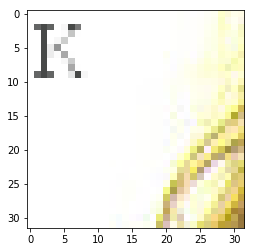

K
(100, 1, 127)
[[ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.        ]
 [ 1.          0.39215686  0.27843137  0.38039216  1.        ]
 [ 1.          1.          0.27843137  1.          1.        ]
 [ 1.          1.          0.27843137  1.          0.96862745]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


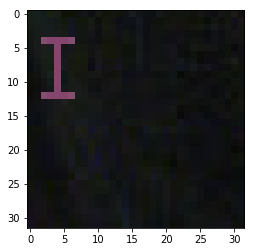

I
(100, 1, 127)
[[ 0.08627451  0.09019608  0.0745098   0.09411765  0.09411765]
 [ 0.09019608  0.08627451  0.08235294  0.08235294  0.0745098 ]
 [ 0.08235294  0.08627451  0.09019608  0.09019608  0.08627451]
 [ 0.0745098   0.08627451  0.09411765  0.09411765  0.10196078]
 [ 0.08235294  0.09019608  0.5254902   0.5254902   0.5254902 ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


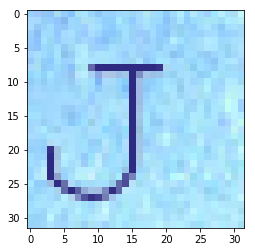

J
(100, 1, 127)
[[ 0.59607843  0.62745098  0.58431373  0.56078431  0.6627451 ]
 [ 0.6627451   0.64705882  0.58431373  0.58823529  0.56862745]
 [ 0.66666667  0.58431373  0.6         0.63137255  0.58431373]
 [ 0.61176471  0.54117647  0.62745098  0.62352941  0.57647059]
 [ 0.6         0.55686275  0.64313725  0.59607843  0.58431373]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


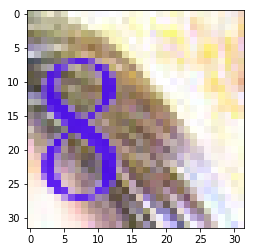

8
(100, 1, 127)
[[ 0.65882353  0.74901961  0.8627451   0.94117647  0.78431373]
 [ 0.6         0.6627451   0.74901961  0.74117647  0.7372549 ]
 [ 0.78431373  0.74509804  0.76470588  0.76862745  0.64705882]
 [ 0.48627451  0.56470588  0.56862745  0.61568627  0.69803922]
 [ 0.53333333  0.49803922  0.58823529  0.58431373  0.56862745]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


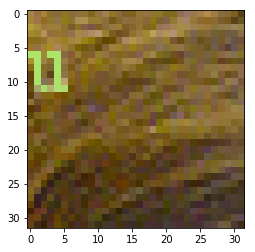

u
(100, 1, 127)
[[ 0.64313725  0.60392157  0.65882353  0.54509804  0.53333333]
 [ 0.62745098  0.62352941  0.57647059  0.55686275  0.56470588]
 [ 0.70196078  0.65882353  0.61960784  0.61176471  0.60784314]
 [ 0.63529412  0.61568627  0.70588235  0.57647059  0.58431373]
 [ 0.54117647  0.52941176  0.56470588  0.6627451   0.63921569]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]


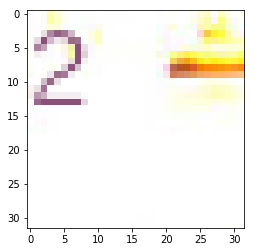

2
(100, 1, 127)
[[ 0.99215686  1.          0.98823529  0.98823529  1.        ]
 [ 0.99607843  1.          0.98823529  0.98431373  0.99607843]
 [ 0.99215686  1.          0.98823529  0.99607843  0.98823529]
 [ 0.99215686  1.          0.91372549  0.68235294  0.57647059]
 [ 0.99215686  0.90196078  0.5372549   0.81176471  0.94117647]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


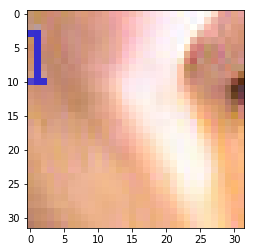

l
(100, 1, 127)
[[ 0.75686275  0.76078431  0.78823529  0.81176471  0.80392157]
 [ 0.74901961  0.75294118  0.78431373  0.79607843  0.78431373]
 [ 0.76078431  0.7254902   0.79607843  0.79215686  0.76470588]
 [ 0.21960784  0.20784314  0.80784314  0.79215686  0.76470588]
 [ 0.78039216  0.20784314  0.80784314  0.78823529  0.77647059]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


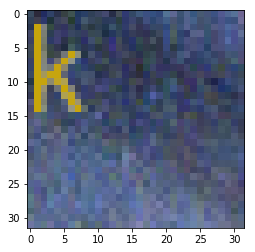

k
(100, 1, 127)
[[ 0.22352941  0.17254902  0.12941176  0.18823529  0.16470588]
 [ 0.19215686  0.25098039  0.17647059  0.11764706  0.22745098]
 [ 0.16078431  0.78039216  0.49411765  0.20784314  0.20392157]
 [ 0.25882353  0.78039216  0.47843137  0.17254902  0.24313725]
 [ 0.23921569  0.78039216  0.4627451   0.17647059  0.25098039]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


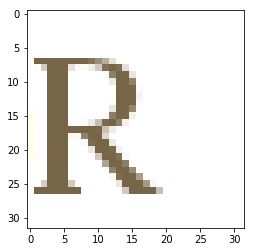

R
(100, 1, 127)
[[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


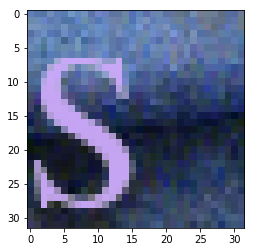

S
(100, 1, 127)
[[ 0.38039216  0.3372549   0.3372549   0.44313725  0.37254902]
 [ 0.42352941  0.41568627  0.41176471  0.37254902  0.38823529]
 [ 0.48235294  0.4627451   0.42745098  0.40392157  0.38039216]
 [ 0.34509804  0.39215686  0.43137255  0.34117647  0.32156863]
 [ 0.39607843  0.42745098  0.34117647  0.41960784  0.37647059]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


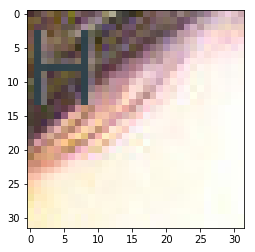

H
(100, 1, 127)
[[ 0.28235294  0.35294118  0.4627451   0.50196078  0.40784314]
 [ 0.45098039  0.45490196  0.36078431  0.42352941  0.41176471]
 [ 0.41176471  0.38431373  0.38039216  0.45098039  0.47058824]
 [ 0.45882353  0.19607843  0.55686275  0.39215686  0.49411765]
 [ 0.47843137  0.19607843  0.57647059  0.52941176  0.54117647]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


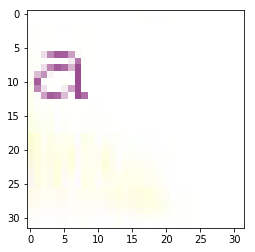

a
(100, 1, 127)
[[ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.        ]
 [ 0.99607843  0.99607843  1.          1.          1.        ]
 [ 0.99607843  0.99607843  1.          1.          1.        ]
 [ 0.99607843  0.99607843  1.          1.          1.        ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


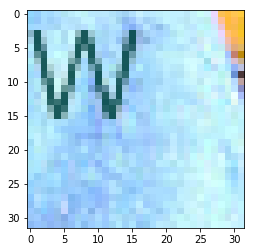

W
(100, 1, 127)
[[ 0.57254902  0.58431373  0.65490196  0.64313725  0.69019608]
 [ 0.54901961  0.58039216  0.65882353  0.61568627  0.65882353]
 [ 0.62352941  0.64705882  0.6627451   0.65490196  0.64313725]
 [ 0.52941176  0.09019608  0.69019608  0.71764706  0.75294118]
 [ 0.65490196  0.08235294  0.60392157  0.71372549  0.74901961]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


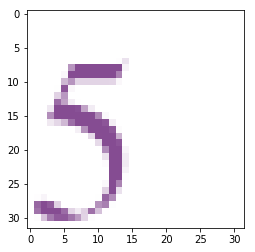

5
(100, 1, 127)
[[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


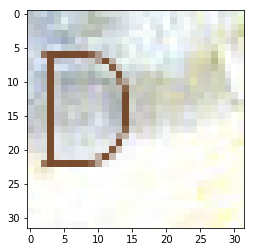

D
(100, 1, 127)
[[ 0.71764706  0.75686275  0.78431373  0.69019608  0.71764706]
 [ 0.7372549   0.71372549  0.69803922  0.68235294  0.74509804]
 [ 0.75686275  0.70196078  0.71764706  0.78039216  0.78431373]
 [ 0.75686275  0.7372549   0.71372549  0.71372549  0.6745098 ]
 [ 0.79215686  0.75294118  0.74117647  0.69411765  0.6745098 ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


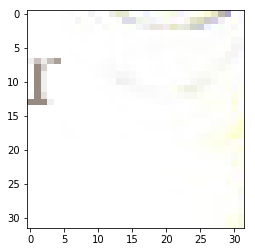

r
(100, 1, 127)
[[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]


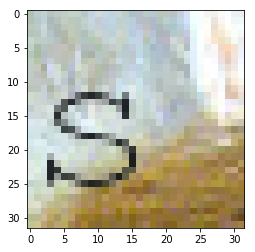

s
(100, 1, 127)
[[ 0.68627451  0.72941176  0.75686275  0.72156863  0.74901961]
 [ 0.70588235  0.70980392  0.75686275  0.67058824  0.70980392]
 [ 0.7372549   0.7372549   0.78823529  0.68235294  0.6745098 ]
 [ 0.71372549  0.7254902   0.78039216  0.70980392  0.67058824]
 [ 0.76470588  0.75294118  0.74509804  0.7254902   0.71372549]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]]


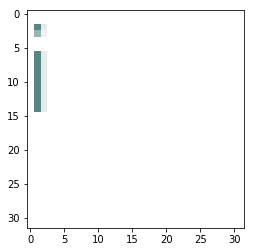

i
(100, 1, 127)
[[ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.        ]
 [ 1.          0.3254902   0.89019608  1.          1.        ]
 [ 1.          0.58431373  0.93333333  1.          1.        ]
 [ 1.          1.          1.          1.          1.        ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


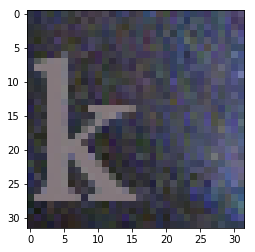

k
(100, 1, 127)
[[ 0.17647059  0.15686275  0.22745098  0.21176471  0.16862745]
 [ 0.19607843  0.14901961  0.22745098  0.19607843  0.2       ]
 [ 0.16862745  0.19215686  0.20392157  0.23921569  0.25098039]
 [ 0.17254902  0.18823529  0.20784314  0.22352941  0.22745098]
 [ 0.19215686  0.16470588  0.21960784  0.19607843  0.28627451]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


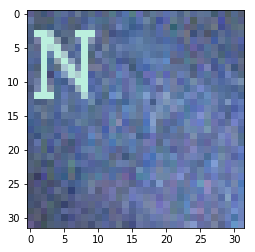

N
(100, 1, 127)
[[ 0.36470588  0.32156863  0.24705882  0.32941176  0.3372549 ]
 [ 0.39215686  0.3254902   0.32941176  0.30588235  0.31764706]
 [ 0.31372549  0.27058824  0.28627451  0.23529412  0.32941176]
 [ 0.31372549  0.73333333  0.73333333  0.65490196  0.28235294]
 [ 0.30196078  0.4745098   0.73333333  0.73333333  0.5372549 ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


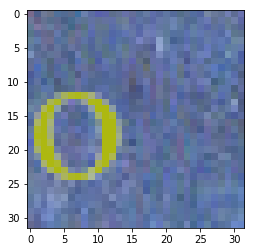

o
(100, 1, 127)
[[ 0.47843137  0.30980392  0.43529412  0.41960784  0.31372549]
 [ 0.43529412  0.39607843  0.39607843  0.34117647  0.36862745]
 [ 0.37647059  0.49803922  0.42745098  0.4         0.4       ]
 [ 0.34117647  0.35686275  0.40392157  0.38431373  0.39215686]
 [ 0.39607843  0.37647059  0.42352941  0.43529412  0.32941176]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


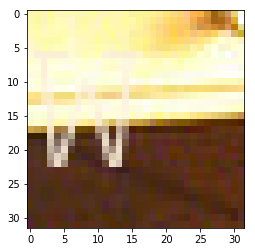

W
(100, 1, 127)
[[ 0.99607843  0.99215686  0.99215686  0.99607843  0.99215686]
 [ 0.99607843  0.98823529  0.98431373  0.99215686  1.        ]
 [ 0.99607843  0.99215686  0.99607843  1.          1.        ]
 [ 1.          1.          0.99607843  0.99607843  0.99607843]
 [ 0.99607843  0.99215686  0.98823529  0.98431373  0.98039216]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


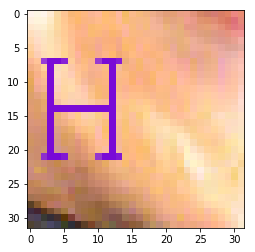

H
(100, 1, 127)
[[ 1.          0.99215686  1.          1.          0.97647059]
 [ 1.          0.99607843  1.          0.99607843  0.98431373]
 [ 1.          0.99215686  0.99215686  0.99215686  0.98823529]
 [ 1.          0.98823529  0.98431373  0.98039216  0.98039216]
 [ 1.          1.          0.99215686  0.98823529  0.98823529]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


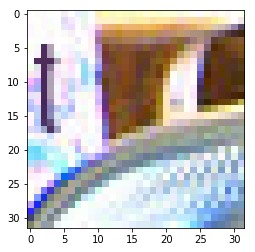

t
(100, 1, 127)
[[ 1.          0.98431373  0.98431373  1.          1.        ]
 [ 1.          0.99215686  1.          0.97254902  0.98823529]
 [ 0.99215686  0.98823529  1.          0.98431373  0.98823529]
 [ 0.99215686  0.98431373  1.          0.98431373  0.99607843]
 [ 1.          0.98431373  0.97647059  1.          1.        ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]]


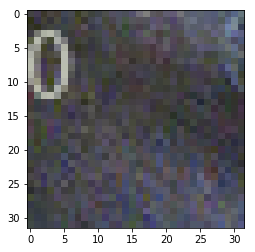

0
(100, 1, 127)
[[ 0.2627451   0.26666667  0.23137255  0.29019608  0.27058824]
 [ 0.18431373  0.21568627  0.2627451   0.20784314  0.28627451]
 [ 0.20784314  0.18039216  0.22745098  0.25490196  0.24313725]
 [ 0.24313725  0.46666667  0.67843137  0.71372549  0.54901961]
 [ 0.35686275  0.71764706  0.40392157  0.26666667  0.6627451 ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


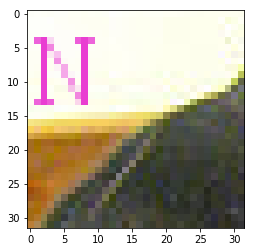

N
(100, 1, 127)
[[ 0.99215686  0.99607843  0.99607843  0.99215686  0.99215686]
 [ 0.99607843  0.99607843  0.99607843  0.99607843  0.99607843]
 [ 0.99607843  0.99607843  0.99607843  0.99607843  0.99607843]
 [ 0.99215686  0.99215686  0.99215686  0.99215686  0.99607843]
 [ 0.99215686  0.92941176  0.91372549  0.97647059  0.99607843]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


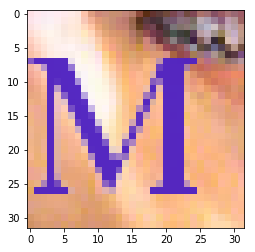

M
(100, 1, 127)
[[ 0.99607843  1.          0.98431373  0.98823529  1.        ]
 [ 0.99215686  0.99607843  0.97647059  0.98431373  0.99607843]
 [ 0.98823529  1.          0.98431373  0.99215686  0.98823529]
 [ 0.99607843  1.          1.          1.          0.99215686]
 [ 0.99607843  1.          1.          1.          0.99607843]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


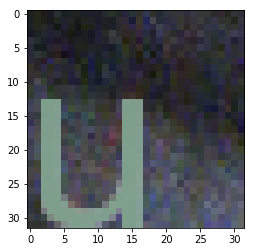

u
(100, 1, 127)
[[ 0.10980392  0.14117647  0.11764706  0.10588235  0.15686275]
 [ 0.10980392  0.14117647  0.11764706  0.09019608  0.12156863]
 [ 0.11372549  0.12941176  0.14509804  0.11764706  0.0745098 ]
 [ 0.08627451  0.11372549  0.13333333  0.12156863  0.1372549 ]
 [ 0.18039216  0.14117647  0.10980392  0.11372549  0.12156863]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]


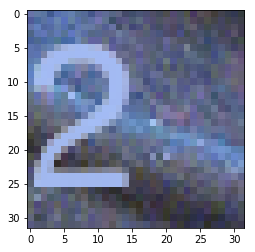

2
(100, 1, 127)
[[ 0.41176471  0.38039216  0.35686275  0.25490196  0.34117647]
 [ 0.31764706  0.29019608  0.35686275  0.34901961  0.40784314]
 [ 0.39215686  0.38823529  0.31764706  0.33333333  0.38431373]
 [ 0.30588235  0.36470588  0.38823529  0.34509804  0.38039216]
 [ 0.28235294  0.30196078  0.29019608  0.31372549  0.30980392]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


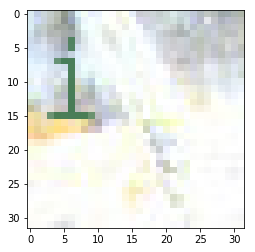

i
(100, 1, 127)
[[ 0.85882353  0.76078431  0.79607843  0.76470588  0.72156863]
 [ 0.85098039  0.81176471  0.78823529  0.76470588  0.70196078]
 [ 0.85490196  0.74901961  0.76470588  0.70196078  0.63137255]
 [ 0.81568627  0.71764706  0.76862745  0.69411765  0.70196078]
 [ 0.80392157  0.77254902  0.83529412  0.74901961  0.72941176]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


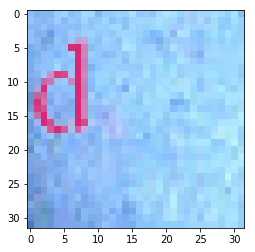

d
(100, 1, 127)
[[ 0.54901961  0.50588235  0.52156863  0.52156863  0.60392157]
 [ 0.58039216  0.5372549   0.53333333  0.55294118  0.61176471]
 [ 0.52941176  0.5254902   0.58039216  0.53333333  0.56078431]
 [ 0.59215686  0.51372549  0.54117647  0.43921569  0.54509804]
 [ 0.57254902  0.5372549   0.46666667  0.47058824  0.57647059]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


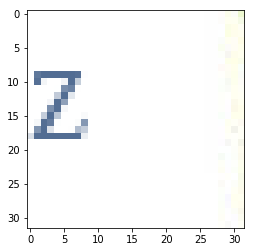

z
(100, 1, 127)
[[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


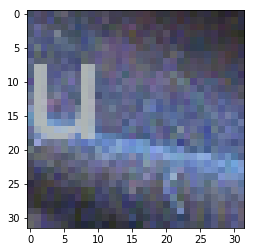

u
(100, 1, 127)
[[ 0.2627451   0.32941176  0.31372549  0.25882353  0.3372549 ]
 [ 0.28627451  0.30196078  0.30588235  0.29019608  0.25882353]
 [ 0.3254902   0.4         0.36862745  0.32156863  0.31372549]
 [ 0.30196078  0.36078431  0.32941176  0.32941176  0.4745098 ]
 [ 0.36078431  0.32156863  0.30196078  0.28627451  0.37647059]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]


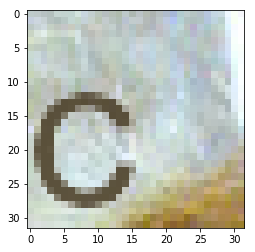

c
(100, 1, 127)
[[ 0.74901961  0.74509804  0.71764706  0.70196078  0.77254902]
 [ 0.77647059  0.80392157  0.78039216  0.71372549  0.68235294]
 [ 0.74117647  0.78039216  0.81176471  0.76862745  0.74901961]
 [ 0.78823529  0.85098039  0.88627451  0.81568627  0.78823529]
 [ 0.84313725  0.81568627  0.8         0.74117647  0.72156863]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


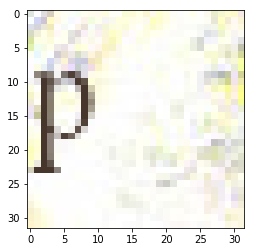

p
(100, 1, 127)
[[ 0.87843137  0.99215686  0.87843137  0.84313725  1.        ]
 [ 0.98431373  0.82352941  0.81176471  1.          1.        ]
 [ 0.8627451   0.83529412  0.91764706  0.94117647  1.        ]
 [ 0.83921569  0.94509804  1.          0.98039216  1.        ]
 [ 0.84313725  0.98823529  0.98823529  0.98823529  1.        ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


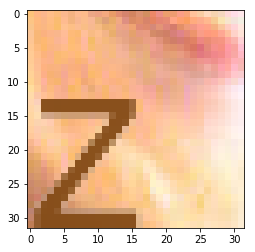

z
(100, 1, 127)
[[ 0.99215686  1.          0.98431373  1.          0.98823529]
 [ 0.98823529  1.          0.98039216  1.          0.98039216]
 [ 0.97647059  0.99215686  0.98039216  0.99607843  0.98039216]
 [ 0.98431373  0.97254902  0.98431373  0.98823529  0.97647059]
 [ 0.99215686  0.97254902  0.99607843  0.99215686  0.98039216]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


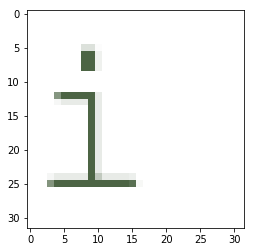

i
(100, 1, 127)
[[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


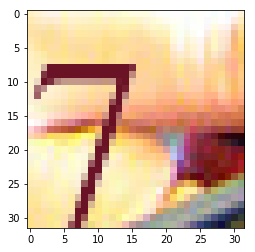

7
(100, 1, 127)
[[ 1.          1.          1.          1.          1.        ]
 [ 1.          0.99607843  0.99215686  0.99607843  1.        ]
 [ 0.99607843  0.98431373  0.98431373  0.98039216  0.99215686]
 [ 0.98823529  0.98823529  0.98039216  0.98039216  0.98823529]
 [ 1.          1.          0.98431373  0.98431373  0.98823529]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


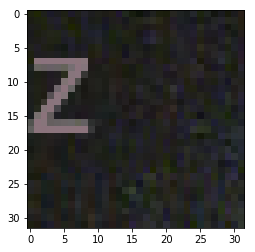

z
(100, 1, 127)
[[ 0.11372549  0.12156863  0.11764706  0.10588235  0.10980392]
 [ 0.10588235  0.11372549  0.12156863  0.12941176  0.12941176]
 [ 0.11372549  0.11372549  0.12156863  0.1254902   0.11764706]
 [ 0.10196078  0.10980392  0.1254902   0.1372549   0.12941176]
 [ 0.10980392  0.11764706  0.12941176  0.12941176  0.12156863]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


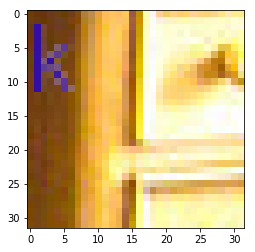

k
(100, 1, 127)
[[ 0.41568627  0.40784314  0.40784314  0.42352941  0.41960784]
 [ 0.41176471  0.40784314  0.40392157  0.41176471  0.41960784]
 [ 0.38823529  0.19607843  0.45882353  0.42745098  0.43137255]
 [ 0.41960784  0.2         0.45098039  0.40392157  0.43529412]
 [ 0.45098039  0.2         0.43529412  0.38431373  0.43529412]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


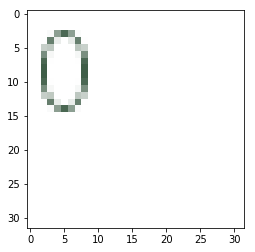

0
(100, 1, 127)
[[ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          1.          0.97647059  0.54901961]
 [ 1.          1.          0.99607843  0.4         0.91764706]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


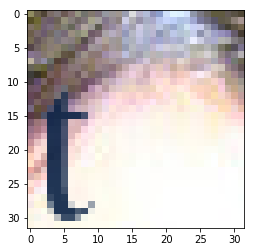

t
(100, 1, 127)
[[ 0.56470588  0.41568627  0.31372549  0.48235294  0.50196078]
 [ 0.33333333  0.42745098  0.44313725  0.41960784  0.42352941]
 [ 0.49411765  0.45882353  0.44705882  0.48627451  0.48235294]
 [ 0.42745098  0.4745098   0.42352941  0.45490196  0.4745098 ]
 [ 0.4627451   0.39607843  0.4745098   0.52941176  0.48627451]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]]


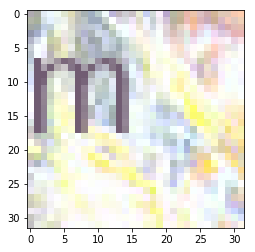

m
(100, 1, 127)
[[ 0.68627451  0.65490196  0.89019608  0.92941176  0.94117647]
 [ 0.69411765  0.65490196  0.83137255  0.89803922  0.90196078]
 [ 0.63921569  0.61960784  0.75294118  0.76078431  0.9372549 ]
 [ 0.57254902  0.64313725  0.84313725  0.74117647  0.94117647]
 [ 0.69803922  0.84705882  0.96862745  0.77647059  0.82745098]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


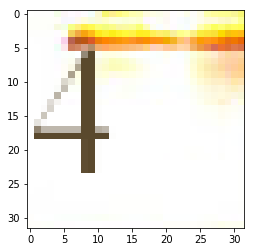

4
(100, 1, 127)
[[ 1.          0.99607843  0.99607843  0.99607843  0.96078431]
 [ 0.99607843  0.99607843  0.99607843  0.99607843  1.        ]
 [ 0.99607843  0.99607843  0.99607843  0.99215686  0.96862745]
 [ 0.99607843  0.99607843  0.99607843  0.99607843  1.        ]
 [ 1.          0.99607843  0.99607843  0.99607843  1.        ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


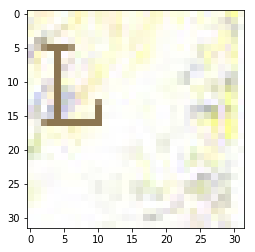

L
(100, 1, 127)
[[ 1.          0.98431373  1.          1.          0.99215686]
 [ 0.92941176  0.98823529  1.          1.          1.        ]
 [ 0.94509804  0.98431373  0.98431373  1.          0.97254902]
 [ 1.          0.99607843  0.8745098   0.92941176  0.91372549]
 [ 1.          0.78039216  0.7254902   0.93333333  0.99607843]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


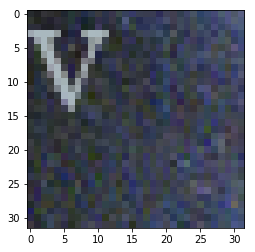

V
(100, 1, 127)
[[ 0.14901961  0.1254902   0.20392157  0.18431373  0.16862745]
 [ 0.19215686  0.13333333  0.14901961  0.13333333  0.18431373]
 [ 0.17254902  0.17647059  0.1254902   0.12156863  0.15686275]
 [ 0.61960784  0.6627451   0.6627451   0.6627451   0.56470588]
 [ 0.20392157  0.58431373  0.6627451   0.51764706  0.17254902]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


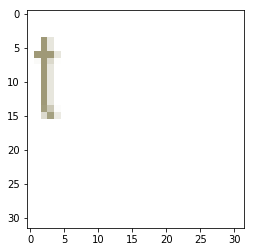

t
(100, 1, 127)
[[ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          0.62352941  0.90588235  1.        ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]]


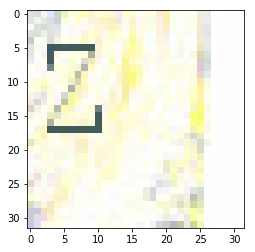

Z
(100, 1, 127)
[[ 0.8745098   0.85490196  0.94901961  0.87843137  0.79607843]
 [ 0.88627451  0.94117647  0.88627451  0.84313725  0.80392157]
 [ 0.96470588  0.85490196  0.82352941  0.86666667  0.87843137]
 [ 0.86666667  0.85098039  0.90980392  0.88235294  0.90980392]
 [ 0.78823529  0.98431373  0.96862745  0.8745098   0.95686275]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


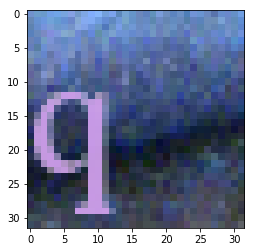

q
(100, 1, 127)
[[ 0.44705882  0.42745098  0.41568627  0.43921569  0.43921569]
 [ 0.40392157  0.4         0.41960784  0.43921569  0.39215686]
 [ 0.36862745  0.40392157  0.46666667  0.48627451  0.42745098]
 [ 0.34901961  0.41568627  0.48235294  0.51372549  0.49019608]
 [ 0.41960784  0.37254902  0.45098039  0.48627451  0.41960784]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]


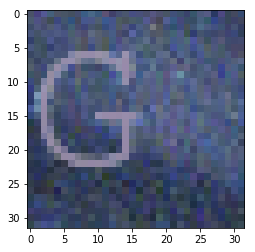

G
(100, 1, 127)
[[ 0.29019608  0.28235294  0.32941176  0.27058824  0.30196078]
 [ 0.29411765  0.30980392  0.29803922  0.25098039  0.23529412]
 [ 0.24313725  0.30980392  0.2745098   0.31372549  0.29803922]
 [ 0.27843137  0.26666667  0.29411765  0.28235294  0.30980392]
 [ 0.2         0.24705882  0.24705882  0.29803922  0.24705882]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


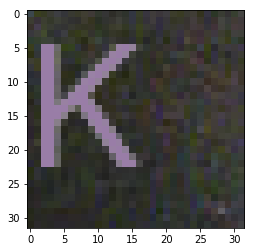

K
(100, 1, 127)
[[ 0.23529412  0.22352941  0.21176471  0.22745098  0.23921569]
 [ 0.23529412  0.21960784  0.23529412  0.20392157  0.23529412]
 [ 0.21960784  0.27058824  0.23921569  0.22352941  0.20392157]
 [ 0.22352941  0.24313725  0.25882353  0.18039216  0.19215686]
 [ 0.17647059  0.2         0.22745098  0.23137255  0.18039216]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


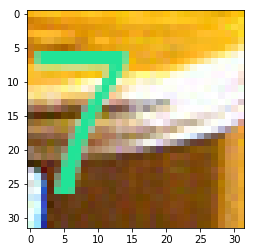

7
(100, 1, 127)
[[ 0.97647059  0.99215686  0.99215686  0.98823529  0.98823529]
 [ 0.81176471  0.84705882  0.8627451   0.8745098   0.89411765]
 [ 0.86666667  0.85490196  0.85098039  0.85882353  0.8745098 ]
 [ 0.99215686  1.          1.          1.          0.98823529]
 [ 0.80392157  0.86666667  0.93333333  0.93333333  0.87843137]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


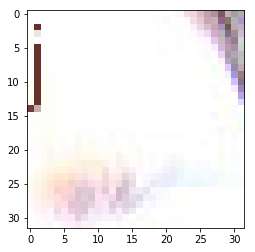

j
(100, 1, 127)
[[ 0.99607843  1.          1.          1.          1.        ]
 [ 0.99607843  1.          1.          1.          1.        ]
 [ 1.          0.39215686  0.99607843  0.99607843  0.99607843]
 [ 1.          0.92156863  0.99607843  0.99607843  0.99607843]
 [ 1.          1.          0.99607843  0.99607843  0.99607843]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


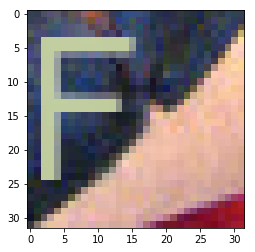

F
(100, 1, 127)
[[ 0.2         0.19607843  0.30196078  0.34117647  0.35294118]
 [ 0.20784314  0.25490196  0.23529412  0.27843137  0.30980392]
 [ 0.2745098   0.27058824  0.32156863  0.25882353  0.23137255]
 [ 0.3254902   0.29019608  0.29411765  0.23137255  0.22745098]
 [ 0.23921569  0.25882353  0.75686275  0.75686275  0.76078431]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


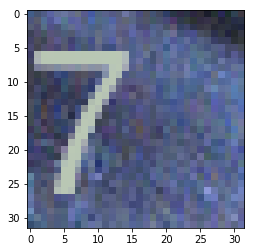

7
(100, 1, 127)
[[ 0.25882353  0.2745098   0.31372549  0.36078431  0.39215686]
 [ 0.30588235  0.34901961  0.32156863  0.32156863  0.4       ]
 [ 0.3372549   0.31372549  0.3372549   0.31764706  0.29411765]
 [ 0.23921569  0.31372549  0.27058824  0.34509804  0.31372549]
 [ 0.2627451   0.30196078  0.23529412  0.35686275  0.35686275]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


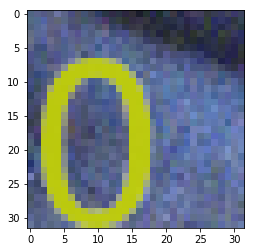

0
(100, 1, 127)
[[ 0.31372549  0.34901961  0.33333333  0.34117647  0.43137255]
 [ 0.3254902   0.31372549  0.32156863  0.36470588  0.37647059]
 [ 0.31764706  0.3372549   0.37647059  0.38431373  0.37647059]
 [ 0.38823529  0.35294118  0.35686275  0.36862745  0.3372549 ]
 [ 0.41568627  0.33333333  0.33333333  0.42352941  0.35294118]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


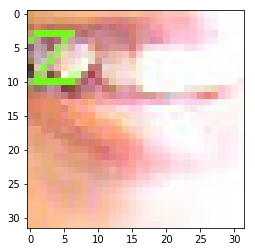

Z
(100, 1, 127)
[[ 0.86666667  0.91372549  0.91764706  0.92941176  0.95294118]
 [ 0.84313725  0.8745098   0.86666667  0.88235294  0.86666667]
 [ 0.73333333  0.83529412  0.77254902  0.74117647  0.73333333]
 [ 0.70588235  0.44705882  0.44705882  0.44705882  0.44705882]
 [ 0.56078431  0.71764706  0.61568627  0.61960784  0.70588235]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


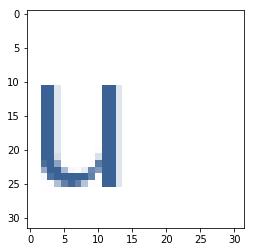

u
(100, 1, 127)
[[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]


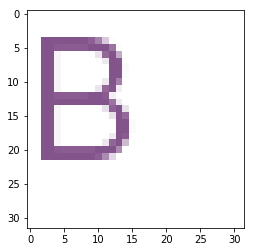

B
(100, 1, 127)
[[ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          0.51372549  0.51372549  0.51372549]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


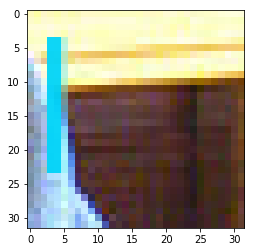

I
(100, 1, 127)
[[ 0.99607843  0.99607843  0.99215686  0.99215686  0.98823529]
 [ 0.99215686  0.99215686  0.99215686  0.99607843  0.99607843]
 [ 1.          1.          1.          1.          1.        ]
 [ 0.99607843  0.99607843  0.99607843  0.99607843  0.99215686]
 [ 0.98039216  0.98431373  0.99215686  0.05490196  0.05490196]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


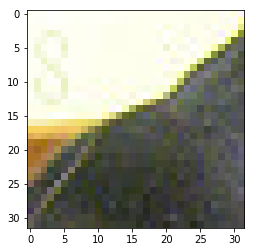

8
(100, 1, 127)
[[ 0.99607843  0.99607843  0.99607843  0.99607843  0.99607843]
 [ 0.99607843  0.99215686  0.99215686  0.99607843  0.99607843]
 [ 0.99607843  0.99607843  0.99607843  0.99607843  0.99607843]
 [ 0.99607843  0.99607843  0.96470588  0.9254902   0.94509804]
 [ 0.99607843  0.96862745  0.96862745  0.99607843  0.98431373]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


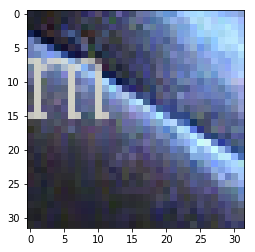

m
(100, 1, 127)
[[ 0.14117647  0.10980392  0.14117647  0.18431373  0.17647059]
 [ 0.12941176  0.11764706  0.15686275  0.19607843  0.18431373]
 [ 0.10588235  0.14117647  0.23529412  0.13333333  0.13333333]
 [ 0.08235294  0.01960784  0.1372549   0.23921569  0.19215686]
 [ 0.43137255  0.28235294  0.04313725  0.03921569  0.16078431]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


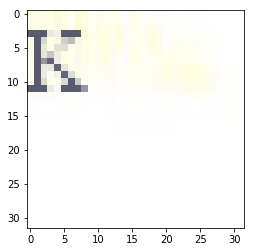

K
(100, 1, 127)
[[ 0.99607843  1.          0.99607843  1.          0.98823529]
 [ 0.99607843  1.          0.99607843  1.          0.98823529]
 [ 0.99607843  0.99607843  0.99607843  1.          0.99215686]
 [ 0.34117647  0.34117647  0.34117647  0.91372549  0.95294118]
 [ 0.97647059  0.34117647  0.85098039  0.99607843  0.98431373]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


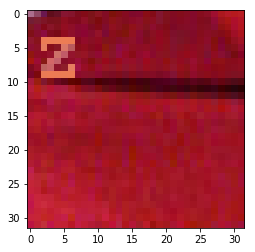

z
(100, 1, 127)
[[ 0.67058824  0.55294118  0.41568627  0.37254902  0.4       ]
 [ 0.44705882  0.48235294  0.49411765  0.4745098   0.47843137]
 [ 0.49411765  0.51764706  0.50980392  0.5372549   0.50588235]
 [ 0.49803922  0.52156863  0.54509804  0.49411765  0.4745098 ]
 [ 0.55686275  0.53333333  0.9254902   0.9254902   0.9254902 ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]]


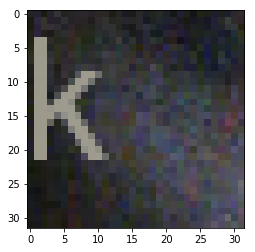

k
(100, 1, 127)
[[ 0.14117647  0.14509804  0.10196078  0.14509804  0.20392157]
 [ 0.10196078  0.18431373  0.21176471  0.14901961  0.1372549 ]
 [ 0.10588235  0.16470588  0.21176471  0.20784314  0.18039216]
 [ 0.12941176  0.17647059  0.14117647  0.11764706  0.16078431]
 [ 0.14117647  0.61568627  0.61960784  0.18431373  0.14509804]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


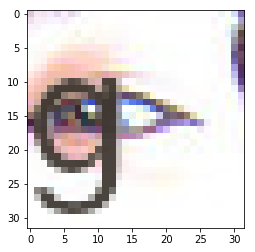

g
(100, 1, 127)
[[ 0.85882353  0.96078431  0.94509804  0.96470588  0.89803922]
 [ 0.94117647  0.97647059  0.96470588  0.96862745  0.98431373]
 [ 0.99215686  0.97254902  0.99215686  0.98823529  1.        ]
 [ 0.98823529  0.99215686  0.99607843  0.98431373  0.98431373]
 [ 1.          1.          0.98431373  0.96862745  0.99607843]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


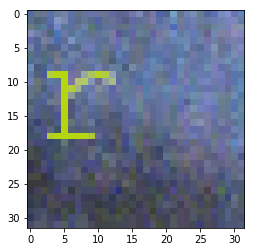

r
(100, 1, 127)
[[ 0.3372549   0.39607843  0.41568627  0.36078431  0.41176471]
 [ 0.34901961  0.30588235  0.32941176  0.35294118  0.50980392]
 [ 0.41960784  0.34901961  0.35294118  0.33333333  0.45882353]
 [ 0.53333333  0.41176471  0.42352941  0.31764706  0.28235294]
 [ 0.40784314  0.32941176  0.4745098   0.41960784  0.29803922]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]]


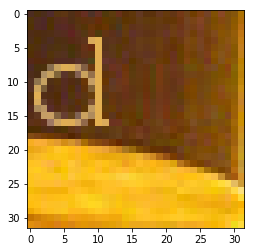

d
(100, 1, 127)
[[ 0.29803922  0.29803922  0.29803922  0.31372549  0.34509804]
 [ 0.31372549  0.31372549  0.30588235  0.30980392  0.3372549 ]
 [ 0.31764706  0.31764706  0.30980392  0.31372549  0.33333333]
 [ 0.30980392  0.30980392  0.30588235  0.31372549  0.3254902 ]
 [ 0.30588235  0.30980392  0.30196078  0.30196078  0.30588235]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


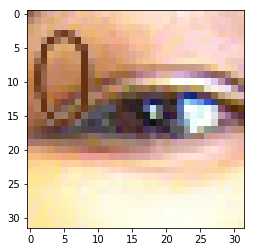

0
(100, 1, 127)
[[ 0.56078431  0.70588235  0.83137255  0.89019608  0.88235294]
 [ 0.69803922  0.80392157  0.8745098   0.87058824  0.87843137]
 [ 0.8         0.85882353  0.9254902   0.89803922  0.89411765]
 [ 0.84313725  0.8745098   0.90588235  0.8         0.52941176]
 [ 0.87058824  0.8745098   0.71372549  0.40784314  0.6       ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


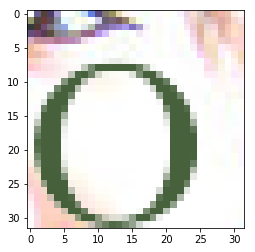

O
(100, 1, 127)
[[ 0.98431373  0.4         0.33333333  0.31372549  0.64705882]
 [ 0.58039216  0.30588235  0.42352941  0.36470588  0.5254902 ]
 [ 0.21960784  0.31372549  0.44705882  0.49019608  0.57254902]
 [ 0.39607843  0.45490196  0.34509804  0.35294118  0.53333333]
 [ 0.84313725  0.76862745  0.74509804  0.75686275  0.69803922]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


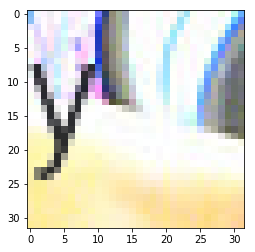

y
(100, 1, 127)
[[ 0.50980392  0.96078431  0.98823529  0.9372549   1.        ]
 [ 0.55686275  0.93333333  1.          0.96862745  1.        ]
 [ 0.9254902   0.86666667  1.          0.97254902  0.94509804]
 [ 1.          0.89019608  0.98823529  1.          0.89803922]
 [ 0.96078431  0.9372549   0.89411765  1.          0.84313725]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]


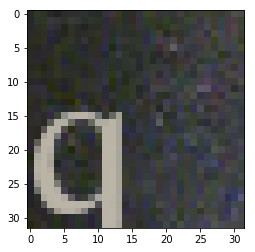

q
(100, 1, 127)
[[ 0.14901961  0.18431373  0.17647059  0.15294118  0.13333333]
 [ 0.14117647  0.17647059  0.18039216  0.21960784  0.20392157]
 [ 0.15294118  0.16862745  0.18039216  0.2         0.18039216]
 [ 0.16470588  0.16862745  0.18039216  0.16470588  0.15294118]
 [ 0.17254902  0.17647059  0.19215686  0.14901961  0.14509804]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]


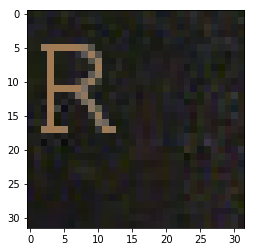

R
(100, 1, 127)
[[ 0.10588235  0.13333333  0.12156863  0.11764706  0.12156863]
 [ 0.09019608  0.11764706  0.12156863  0.09019608  0.09803922]
 [ 0.12941176  0.13333333  0.13333333  0.10196078  0.11764706]
 [ 0.13333333  0.11372549  0.12156863  0.10980392  0.12156863]
 [ 0.12941176  0.11764706  0.10980392  0.11372549  0.12156863]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


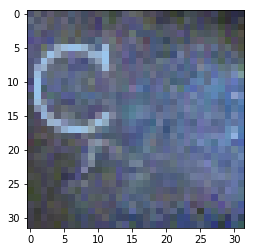

C
(100, 1, 127)
[[ 0.30588235  0.38039216  0.29411765  0.37647059  0.30980392]
 [ 0.39215686  0.31372549  0.38039216  0.36862745  0.3254902 ]
 [ 0.30588235  0.38431373  0.4         0.33333333  0.3254902 ]
 [ 0.32156863  0.35686275  0.31372549  0.32156863  0.33333333]
 [ 0.3254902   0.36078431  0.32941176  0.28235294  0.36078431]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


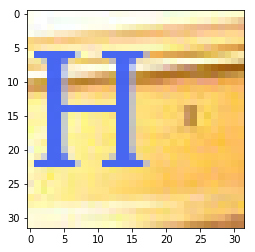

H
(100, 1, 127)
[[ 1.          1.          0.99607843  0.98431373  1.        ]
 [ 0.99607843  0.99607843  0.99607843  0.96470588  0.95294118]
 [ 0.98039216  0.97647059  1.          1.          0.97647059]
 [ 0.98823529  0.96078431  0.96862745  0.98039216  0.98431373]
 [ 0.97647059  0.97254902  0.97254902  0.96862745  0.99607843]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


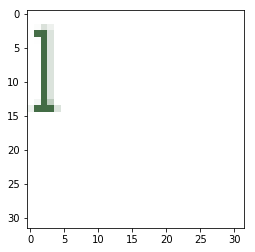

l
(100, 1, 127)
[[ 1.          1.          1.          1.          1.        ]
 [ 1.          1.          1.          1.          1.        ]
 [ 1.          0.98431373  0.85490196  0.93333333  1.        ]
 [ 1.          0.2745098   0.2627451   0.85882353  1.        ]
 [ 1.          0.99607843  0.2627451   0.85882353  1.        ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


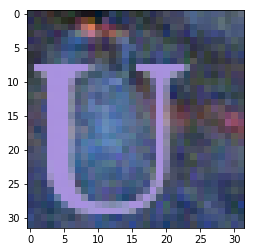

U
(100, 1, 127)
[[ 0.18823529  0.20392157  0.23529412  0.25098039  0.14901961]
 [ 0.15686275  0.20784314  0.19607843  0.24313725  0.21568627]
 [ 0.21176471  0.18039216  0.17647059  0.2         0.27843137]
 [ 0.21176471  0.27843137  0.24705882  0.18431373  0.23137255]
 [ 0.18823529  0.21568627  0.23137255  0.16078431  0.24705882]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


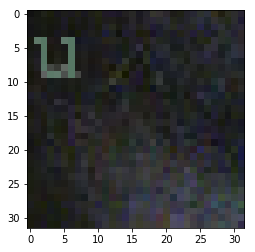

u
(100, 1, 127)
[[ 0.06666667  0.08235294  0.12156863  0.10588235  0.09411765]
 [ 0.09411765  0.09019608  0.09411765  0.09019608  0.09411765]
 [ 0.07843137  0.08627451  0.09803922  0.08235294  0.09019608]
 [ 0.08235294  0.08235294  0.09019608  0.08235294  0.09411765]
 [ 0.08627451  0.37254902  0.34117647  0.1254902   0.10588235]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]


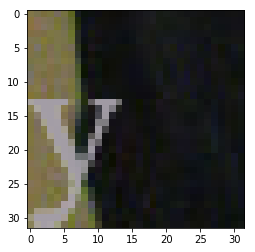

y
(100, 1, 127)
[[ 0.50588235  0.4745098   0.4745098   0.4745098   0.46666667]
 [ 0.53333333  0.53333333  0.50588235  0.48235294  0.46666667]
 [ 0.54509804  0.54509804  0.50980392  0.49411765  0.47843137]
 [ 0.50588235  0.50196078  0.48627451  0.49019608  0.48627451]
 [ 0.49019608  0.48235294  0.51372549  0.4745098   0.48627451]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]]


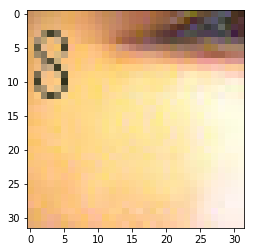

8
(100, 1, 127)
[[ 0.78039216  0.80784314  0.83529412  0.84705882  0.86666667]
 [ 0.80392157  0.83921569  0.86666667  0.87843137  0.89803922]
 [ 0.84313725  0.87843137  0.89803922  0.90588235  0.91764706]
 [ 0.86666667  0.89411765  0.58431373  0.25882353  0.4627451 ]
 [ 0.90196078  0.65490196  0.75294118  0.94901961  0.85490196]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


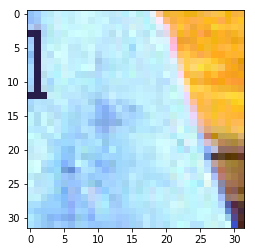

l
(100, 1, 127)
[[ 0.57254902  0.62352941  0.70588235  0.72156863  0.79607843]
 [ 0.58039216  0.61960784  0.70980392  0.74117647  0.80784314]
 [ 0.69019608  0.64705882  0.69019608  0.71764706  0.81568627]
 [ 0.15686275  0.14901961  0.68235294  0.70196078  0.76078431]
 [ 0.63137255  0.14901961  0.70980392  0.70980392  0.74509804]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


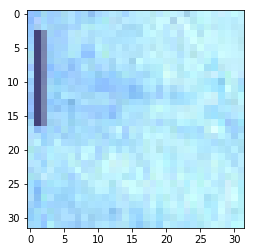

l
(100, 1, 127)
[[ 0.57647059  0.54509804  0.63137255  0.61176471  0.62352941]
 [ 0.54509804  0.69411765  0.62745098  0.62352941  0.63137255]
 [ 0.57647059  0.64313725  0.65490196  0.63529412  0.61176471]
 [ 0.58039216  0.2627451   0.47843137  0.62352941  0.61960784]
 [ 0.6         0.2627451   0.4745098   0.62352941  0.63921569]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


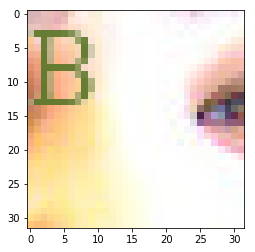

B
(100, 1, 127)
[[ 0.83137255  0.84705882  0.90196078  0.90980392  0.91764706]
 [ 0.84313725  0.8745098   0.90588235  0.90980392  0.90588235]
 [ 0.90980392  0.9254902   0.91764706  0.92156863  0.96078431]
 [ 0.80784314  0.40392157  0.4         0.4         0.40392157]
 [ 0.96862745  0.97254902  0.40392157  0.72941176  0.98823529]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


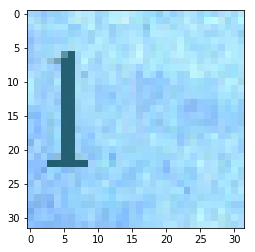

1
(100, 1, 127)
[[ 0.63137255  0.61568627  0.56470588  0.59215686  0.58039216]
 [ 0.69411765  0.65098039  0.59607843  0.64313725  0.58431373]
 [ 0.65098039  0.70196078  0.62745098  0.63921569  0.67843137]
 [ 0.60784314  0.65490196  0.59215686  0.60784314  0.63529412]
 [ 0.55686275  0.63137255  0.58823529  0.58039216  0.61176471]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


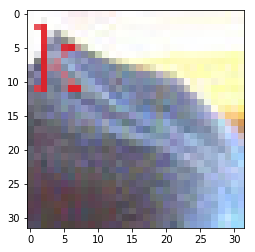

k
(100, 1, 127)
[[ 0.98823529  1.          1.          0.99215686  0.98823529]
 [ 0.99215686  1.          0.94117647  1.          1.        ]
 [ 1.          0.90980392  0.89019608  1.          0.98039216]
 [ 0.98823529  0.99607843  0.89019608  0.88235294  0.64313725]
 [ 0.98431373  1.          0.89019608  0.65882353  0.50980392]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


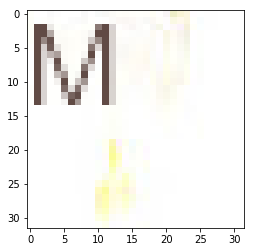

M
(100, 1, 127)
[[ 0.99607843  1.          1.          0.98039216  0.99215686]
 [ 0.99215686  0.99215686  0.99607843  0.98823529  1.        ]
 [ 0.99215686  0.37647059  0.38039216  0.92156863  0.99607843]
 [ 0.99215686  0.38039216  0.38039216  0.70196078  0.99215686]
 [ 0.99215686  0.38039216  0.59215686  0.41176471  0.98823529]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


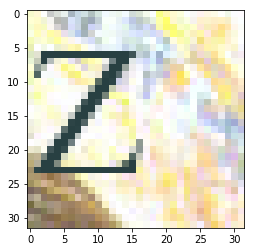

Z
(100, 1, 127)
[[ 0.96862745  1.          0.99607843  0.78431373  0.85098039]
 [ 1.          1.          0.94509804  0.96470588  0.70980392]
 [ 0.96470588  0.99607843  0.96862745  0.98823529  0.83529412]
 [ 0.97647059  1.          0.99215686  1.          1.        ]
 [ 0.95686275  0.97254902  0.99607843  0.96470588  1.        ]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


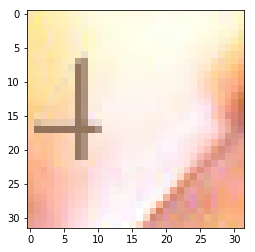

4
(100, 1, 127)
[[ 0.98823529  0.99215686  1.          0.99607843  0.99607843]
 [ 0.98431373  0.99607843  1.          0.99215686  0.99607843]
 [ 0.99215686  0.99215686  1.          0.99607843  0.99607843]
 [ 0.99215686  0.99215686  1.          0.99607843  0.99607843]
 [ 0.99215686  0.98823529  0.99215686  0.99607843  0.99607843]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


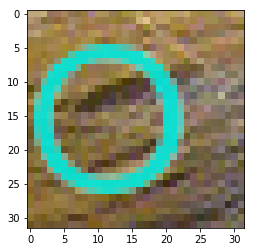

O
(100, 1, 127)
[[ 0.74117647  0.74901961  0.76862745  0.57647059  0.62352941]
 [ 0.69803922  0.65490196  0.50588235  0.55294118  0.56078431]
 [ 0.62352941  0.63529412  0.62352941  0.64313725  0.73333333]
 [ 0.68627451  0.74509804  0.65098039  0.64313725  0.61960784]
 [ 0.58431373  0.6         0.59215686  0.61176471  0.63921569]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


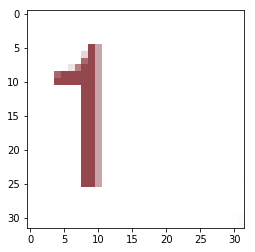

1
(100, 1, 127)
[[ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


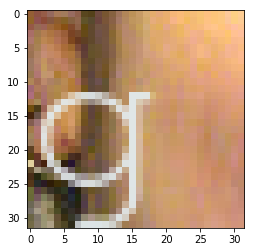

g
(100, 1, 127)
[[ 0.58039216  0.55294118  0.58823529  0.58431373  0.65490196]
 [ 0.56862745  0.56078431  0.54901961  0.52156863  0.55294118]
 [ 0.58823529  0.58431373  0.61176471  0.61568627  0.59215686]
 [ 0.6627451   0.62745098  0.70196078  0.67843137  0.65882353]
 [ 0.68235294  0.64705882  0.7372549   0.71764706  0.69411765]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


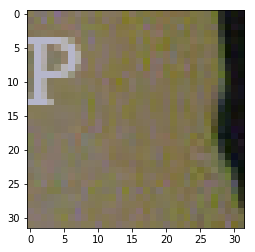

P
(100, 1, 127)
[[ 0.5254902   0.50196078  0.49803922  0.51764706  0.5254902 ]
 [ 0.49019608  0.50588235  0.51764706  0.50980392  0.5254902 ]
 [ 0.50588235  0.53333333  0.52941176  0.50588235  0.51764706]
 [ 0.50588235  0.50980392  0.52156863  0.52941176  0.52156863]
 [ 0.71372549  0.70980392  0.70980392  0.71372549  0.71764706]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


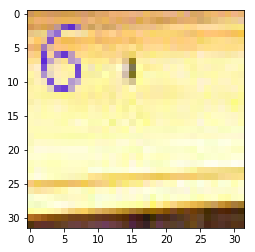

6
(100, 1, 127)
[[ 0.80392157  0.84705882  0.83921569  0.82745098  0.81568627]
 [ 0.88627451  0.9372549   0.92941176  0.91764706  0.91372549]
 [ 0.83529412  0.8627451   0.84705882  0.82352941  0.74509804]
 [ 0.90980392  0.90588235  0.92156863  0.70980392  0.56862745]
 [ 0.99607843  1.          0.93333333  0.51372549  0.97647059]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


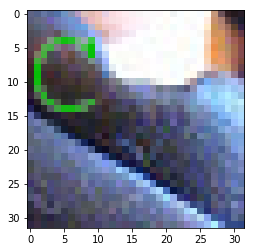

C
(100, 1, 127)
[[ 0.37254902  0.32941176  0.4         0.34509804  0.3254902 ]
 [ 0.35686275  0.39215686  0.41568627  0.43529412  0.44313725]
 [ 0.35294118  0.32941176  0.37254902  0.41176471  0.41960784]
 [ 0.31372549  0.32156863  0.38431373  0.41960784  0.37647059]
 [ 0.31372549  0.38823529  0.44313725  0.49019608  0.23921569]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [153]:
batch_size = 100
gen = generator("./train2014/*.jpg", batch_size=batch_size, enable_distortion=False)
x, y = next(gen)
for i in range(0, x.shape[0]):
    plt.imshow(Image.fromarray((x[i,:,:,:]*255).astype(numpy.uint8)))
    plt.show()
    print(chr(numpy.argmax(y[i][0])))
    print(y.shape)
    print(x[i,:5,:5,0])
    print(y[i,:])

Training meta-epoch 0
Epoch 1/100
10/10 [==============================] - 11s - loss: 5.2730     
Epoch 2/100
10/10 [==============================] - 10s - loss: 5.1486    

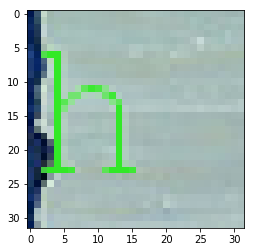

Character guesses:
L : 0.024448739364743233
H : 0.0259131770581007
P : 0.02835157886147499
Z : 0.05580202862620354
S : 0.028470531105995178
Correct answer:
h
Middle character distribution:
[  3.92103830e-05   2.21013306e-05   2.16322642e-05   3.41158739e-05
   3.56763230e-05   2.92481673e-05   3.05069207e-05   3.28032365e-05
   2.24899195e-05   2.25855219e-05   1.64200464e-05   2.14990941e-05
   2.31772974e-05   1.08345394e-05   3.06010224e-05   1.60134041e-05
   2.42754613e-05   1.78249829e-05   2.18360419e-05   1.72699438e-05
   2.82871533e-05   1.92248644e-05   4.98994450e-05   1.73725730e-05
   1.91738800e-05   1.89460716e-05   2.78287825e-05   3.60310005e-05
   3.23777786e-05   2.05081542e-05   2.21321152e-05   1.77212332e-05
   1.66020382e-05   2.35611878e-05   3.01755226e-05   2.83859372e-05
   2.26060383e-05   2.03242962e-05   2.95635709e-05   9.99930853e-06
   2.07934590e-05   1.69853902e-05   2.78154239e-05   5.87283876e-06
   4.32417582e-05   5.94384583e-05   1.74692505e-05 

In [ ]:
#shutil.rmtree("/tmp/logs_tboard/")
#checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1) # save_best_only=True
#tb = TensorBoard(log_dir='/tmp/logs_tboard', histogram_freq=0, batch_size=10, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
# Add `callbacks=[tb, checkpointer]` to train to use these.
# Run TB with `tensorboard --logdir=/full_path_to_your_logs`

meta_epochs = 100
epochs = 100
steps_per_epoch = 10
for i in range(meta_epochs):
    print("Training meta-epoch {}".format(i))
    #performance = 0
    #for _ in range(steps_per_epoch): # Steps per epoch
    #    x, y = next(gen)
    #    performance += model.train_on_batch(x, y)
    #performance /= steps_per_epoch
    #print("Epoch {}: {}".format(i, performance))
    hist = model.fit_generator(gen, epochs=epochs, steps_per_epoch=steps_per_epoch) # Yield 1000 batches of 10 items from generator per epoch.
    if i%1 == 0:
        x, y = next(gen)
        prediction = model.predict(x)
        print("Sample from epoch {}".format(i))
        plt.imshow(Image.fromarray((x[0,:,:,:]*255).astype(numpy.uint8)))
        plt.show()
        print("Character guesses:")
        guess_indices = numpy.argpartition(prediction[0,0,:], -5)[-5:]
        for ind in guess_indices:
            c = chr(ind)
            print("{} : {}".format(c, prediction[0,0,ind]))
        print("Correct answer:")
        c = chr(numpy.argmax(y[0,0,:]))
        print("{}".format(c))
        print("Middle character distribution:")
        print(prediction[0,0,:])
    if i%1 == 0:
        print("Checkpointing.  Saving model.")
        model.save("ocr.h5")
    # These are no longer necessary with our callbacks.
    ignore = """
    if i%1 == 0:
        fout = open("/tmp/log_status_meta_epoch_{}.log".format(i), 'wt')
        pickle.dump(hist, fout, -1)
        fout.close()
    """

In [145]:
#model.save("ocr.h5")
#model.predict(x[:,:,:])
guess_indices = numpy.argpartition(prediction[0,0,:], -5)[-5:]
for ind in guess_indices:
    c = chr(ind)
    print("{} : {}".format(c, prediction[0,0,ind]))

p : 0.019012652337551117
O : 0.021729962900280952
z : 0.01914997398853302
K : 0.023941239342093468
g : 0.019598552957177162


In [117]:
K.clear_session()

In [118]:
shutil.rmtree("/tmp/logs_tboard/")